In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.kernels import LinearMultiFidelityKernel
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

import matplotlib.pyplot as plt
from matplotlib import colors
import mlai.plot as plot

## The simulators

In [2]:
# Simulation presettings
write_images = False
wirte_output_txt = False
%run Missile_utils.ipynb
simulation_output = 'range'

In [3]:
custom_param_names = ['fuelmass', 'drymass']

### Low fidelity

In [4]:
# Low-fidelity simulator class
class simple_simulator_mod:
    def __init__(self,fuelmass,drymass,payload,missilediam,params=True):
        self.dMdt = 500
        self.v_ex = 5000
        
        if params is None:
            self.drymass = 0.8e6
            self.fuelmass = 2e6
            self.diam = 1.65
            
        else:
            self.drymass = drymass + payload
            self.fuelmass = fuelmass
            self.diam = missilediam
    
    def get_range(self):
        h=1e-5
        v=1e-5
        gamma = self.to_radians(90)
        thrust = self.v_ex * self.dMdt
        mass = self.drymass + self.fuelmass
        area = pi*(self.diam**2)/4
        G = 6.6743e-11
        M = 5.972e24
        R = 6.371e6
        g = G*M/(R**2)
        dm = self.dMdt
        t=0
        psi=0
        dt=1e-1
        tEND=1e8
        heights = []
        velocity = []
        gammas = []
        cnt=0
        while(h>0):
            if t>tEND:
                break
            try:
                dv = thrust/mass - g*sin(gamma)
            except:
                dv = 0
            dpsi = v*cos(gamma)/(R+h)
            dh = v*sin(gamma)
            if t<5:
                dgamma = -0.1
            else:
                dgamma = dpsi - g*cos(gamma)/v
                
            if mass <= self.drymass:
                thrust=0
                mass = self.drymass
                dm=0
                
            else:
                mass = mass - dm*dt
    
            v = v + dt*dv
            h = h + dt*dh
            heights.append(h)

            gamma = gamma + dt*dgamma
            gammas.append(gamma)
            psi = psi + dt*dpsi
            g =  G*M/((R+h)**2)
            t= t+dt
            velocity.append(v)
            
        if psi<0:
            print("Rocket Failed (PSI)")
            return 0
        if t>tEND:
            print("Rocket Failed (tend)")
            return 0
        return psi*R/1000
        
        
    def eta(self,h,t):
        eta = 0.0
        return eta      
    
    def density(self,h):
        "Calculates air density at altitude"    
        rho0 = 1.225 #[kg/m^3] air density at sea level
        if h < 19200:
            rho = rho0 * exp(-h/8420)
        elif h > 19200 and h < 47000:
            rho = rho0 * (.857003 + h/57947)**-13.201
        else:
            #vacuum
            rho = 0.0
        return rho
        
    def temperature(self,h):
        "Calculates air temperature [Celsius] at altitude [m]"
        if h <= 11000:
            #troposphere
            t = 15.04 - .00649*h
        elif h <= 25000:
            #lower stratosphere
            t = -56.46
        elif h > 25000:
            t = -131.21 + .00299*h
        return t
    
    def pressure(self,h):
        "Calculates air pressure [Pa] at altitude [m]"  
        t = self.temperature(h)      
        if h <= 11000:
            #troposphere
            p = 101.29 * ((t+273.1)/288.08)**5.256
        elif h <= 25000:
            #lower stratosphere
            p = 22.65*exp(1.73-.000157*h)
        elif h > 25000:
            p = 2.488 * ((t+273.1)/288.08)**-11.388
        return p
        
    def Cdrag (self,v,h):
        t = self.temperature(h) + 273.15 #convert to kelvin
        a = sqrt(1.4*287*t) 
        mach = v/a
        
        if mach > 5:
            cd = 0.15
        elif mach > 1.8 and mach <= 5:
            cd = -0.03125*mach + 0.30625
        elif mach > 1.2 and mach <= 1.8:
            cd = -0.25*mach + 0.7
        elif mach > 0.8 and mach <= 1.2:
            cd = 0.625*mach - 0.35
        elif mach <= 0.8:
            cd = 0.15
        return cd
        
    def to_radians(self,degree):
        return degree * pi/180

In [5]:
# Low-fidelity simulation helper. Correct for the input type we want
def run_missile_low_sim(custom_params):
    """    
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'fuelmass':5600,
        'drymass':1200,
        'Isp0':226,
        'thrust0':9177.4
    }
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        # Row: different parameters -> different runs from the simulator
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            # For each custom variable
            param_name = custom_param_names[j]
            params_to_use[param_name] = custom_params[i,j]
        
            ## TEMP ## Better customise this
            #if j==0:
            #    print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            #print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_obj = simple_simulator_mod( 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"],
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],
        )
        Tm = 1.4e4*2000 / (params_to_use["fuelmass"]+params_to_use["drymass"])
        g = 6.6743e-11*5.972e24/(6.371e6**2)
        if Tm < g:
            print("Tm<g -> will fail")
        #print(f'Fuel {params_to_use["fuelmass"]}, dry {params_to_use["drymass"]}')
        
        y[i, 0] = sim_obj.get_range()
        if y[i, 0] ==0:
            print("FAILED")
    return y


### High fidelity
Note that the high-fidelity simulator itself is in a different file

In [6]:
# High-fidelity simulator helper
def run_missile_high_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }   
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
        
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


## The simulators

In [64]:
# This is the default range of parameters for high fidelity simulator
basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000],
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],
    'thrust0':  [10000, 69000],
}

In [65]:
high_f = run_missile_high_sim
low_f = run_missile_low_sim

num_points = 101

x_dry = np.linspace(1000, 3000,num_points)[:, None]
x_fuel = np.linspace(500, 6000,num_points)[:, None]
x_fmesh, x_dmesh = np.meshgrid(x_fuel, x_dry)
x_plot = np.array([x_fmesh, x_dmesh]).T.reshape(-1,2)

y_plot_low = low_f(x_plot) # Quite slow

In [ ]:
y_plot_high = high_f(x_plot) # Very slow

### Simulators' test points

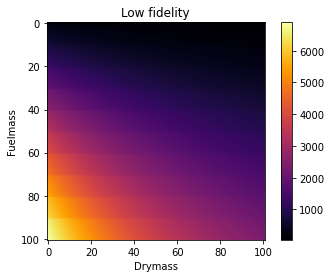

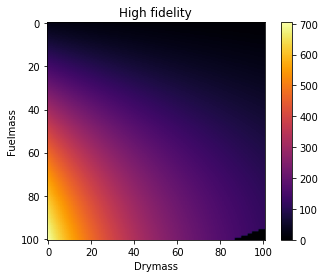

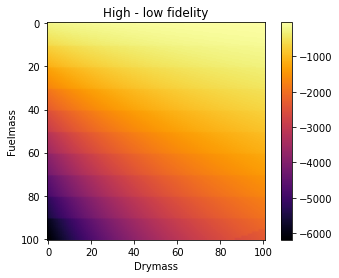

In [67]:
y_plot_low = y_plot_low.reshape(num_points**2, 1)
y_plot_hihg = y_plot_high.reshape(num_points**2, 1)

# Low-fidelity plot original
y_plot_low_im = y_plot_low.reshape(num_points, num_points)
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Low fidelity')
im_low = ax.imshow(y_plot_low_im, cmap='inferno')
fig.colorbar(im_low, ax=ax)

# High-fidelity plot original
y_plot_high_im = y_plot_high.reshape(num_points, num_points)
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('High fidelity')
im_high = ax.imshow(y_plot_high_im, cmap='inferno')
fig.colorbar(im_high, ax=ax)
plt.show()

# Difference
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('High - low fidelity')
im_diff = ax.imshow(y_plot_high_im - y_plot_low_im, cmap='inferno')
fig.colorbar(im_diff, ax=ax)
plt.show()


The difference is not smooth

## Training data for the models

In [119]:
np.random.seed(123456)
num_high_points = 6
x_train_fuel = np.random.uniform(500, 6000, 12)[:, np.newaxis]
x_train_dry = np.random.uniform(1000, 3000, 12)[:, np.newaxis]
x_train_low = np.column_stack((x_train_fuel, x_train_dry))
x_train_high = np.random.permutation(x_train_low)[:num_high_points]

y_train_low = low_f(x_train_low)
y_train_high = high_f(x_train_high)

X_train, Y_train = convert_xy_lists_to_arrays([x_train_low, x_train_high], 
                                                    [y_train_low, y_train_high])


New simulation 

fuelmass: 2982.570587614698
drymass: 2189.5671789702474


Stage 1 burnout
Velocity (km/s):  0.932510515481913
Angle (deg h):  43.64050127675686
Range (km):  13.653654745019104
Time (sec):  73.5000000000001
Final results: 
Range (km):  122.3281815329527
Apogee (km):  43.598404466549454
Time to target (sec):  235.5999999999909



New simulation 

fuelmass: 1177.061793586748
drymass: 2705.799561897724


Stage 1 burnout
Velocity (km/s):  0.4097301173928278
Angle (deg h):  43.718048353520324
Range (km):  2.5551700448915957
Time (sec):  29.000000000000146
Final results: 
Range (km):  23.671523909073382
Apogee (km):  8.77216076870598
Time to target (sec):  100.39999999999857



New simulation 

fuelmass: 5121.402957937597
drymass: 1275.107113126541


Stage 1 burnout
Velocity (km/s):  1.896671757436499
Angle (deg h):  43.65776637115843
Range (km):  39.30189670767577
Time (sec):  126.09999999999711
Final results: 
Range (km):  474.4283820099072
Apogee (km):  151.63313390648264

## Standard GP on high-fidelity points

In [132]:
# Making and optimising the model
m2_kern = (GPy.kern.RBF(2, lengthscale=5000) * \
           GPy.kern.RBF(2, lengthscale=1000)) + \
            GPy.kern.Linear(2)

kernel = m2_kern.copy()
high_gp_model = GPy.models.GPRegression(x_train_high, y_train_high, kernel)
high_gp_model.Gaussian_noise.fix(0)
high_gp_model.optimize_restarts(5)
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(x_plot)
hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)

Optimization restart 1/5, f = 37.12067694104771
Optimization restart 2/5, f = 39.22463131049781
Optimization restart 3/5, f = 39.224631293082815
Optimization restart 4/5, f = 39.22463129326385
Optimization restart 5/5, f = 39.22463129305657


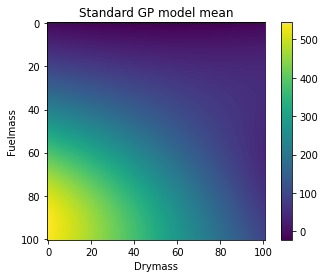

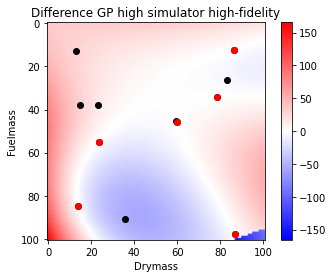

In [148]:
# Plot the posterior mean for the high-fidelity GP
hf_mean_gp = hf_mean_high_gp_model.reshape(num_points, num_points)

# Training points scaled to the plot as the test points
x_th_scaled = x_train_high.copy()
x_th_scaled[:,0] = (x_th_scaled[:,0]-500)/(5500)*101
x_th_scaled[:,1] = (x_th_scaled[:,1]-1000)/(2000)*101

x_tl_scaled = x_train_low.copy()
x_tl_scaled[:,0] = (x_tl_scaled[:,0]-500)/(5500)*101
x_tl_scaled[:,1] = (x_tl_scaled[:,1]-1000)/(2000)*101


# Mean
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Standard GP model mean')
im_high_mean = ax.imshow(hf_mean_gp)
fig.colorbar(im_high_mean, ax=ax)
plt.show()

# Difference
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Difference GP high simulator high-fidelity')
im_diff = ax.imshow(y_plot_high_im - hf_mean_gp, cmap='bwr', norm=colors.CenteredNorm())

ax.plot(x_tl_scaled[:,1], x_tl_scaled[:,0], 'ko')
ax.plot(x_th_scaled[:,1], x_th_scaled[:,0], 'ro') #Drymass,fuelmass
fig.colorbar(im_diff, ax=ax)
plt.show()

In [134]:
rmse_gp = np.sqrt(np.mean(np.square(y_plot_high_im - hf_mean_gp)))
print(rmse_gp)

30.51939615604498


## Linear multifidelity model

In [135]:
kernels = [m2_kern.copy(), m2_kern.copy()]
lin_mf_kernel = LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)

array([0])

In [136]:
# Wrapping the model to emukit
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
# Fit the model - optimize hyperparameters
lin_mf_model.optimize()

Optimization restart 1/5, f = 123.74124601425837
Optimization restart 2/5, f = 127.64260975177955
Optimization restart 3/5, f = 127.64260976300173
Optimization restart 4/5, f = 127.64260968317845
Optimization restart 5/5, f = 127.6426096980599


In [137]:
# Convert to ndarray representation
X_plot = convert_x_list_to_array([x_plot, x_plot])
X_plot_l = X_plot[:len(x_plot)]
X_plot_h = X_plot[len(x_plot):]

# Find mean and variances. We will only consider mean
lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
#lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
#hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

#### Linear MF results

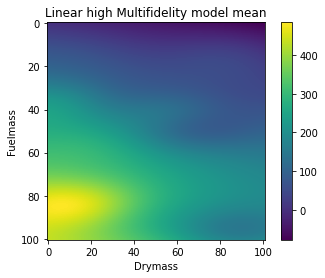

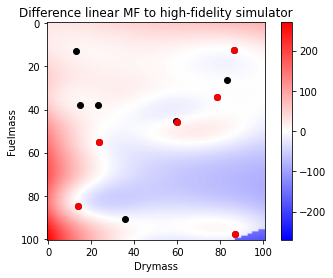

In [146]:
lf_mean_lin_plot = lf_mean_lin_mf_model.reshape(num_points, num_points)
hf_mean_lin_plot = hf_mean_lin_mf_model.reshape(num_points, num_points)

# Mean high fidelity
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Linear high Multifidelity model mean')
im_h_mean = ax.imshow(hf_mean_lin_plot)
fig.colorbar(im_h_mean, ax=ax)
plt.show()

# Difference low fidelity
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Difference linear MF to high-fidelity simulator')
im_diff = ax.imshow(y_plot_high_im - hf_mean_lin_plot, cmap='bwr', norm=colors.CenteredNorm())

ax.plot(x_tl_scaled[:,1], x_tl_scaled[:,0], 'ko')
ax.plot(x_th_scaled[:,1], x_th_scaled[:,0], 'ro') #Drymass,fuelmass
fig.colorbar(im_diff, ax=ax)
plt.show()

In [139]:
rmse_mf_lin = np.sqrt(np.mean(np.square(y_plot_high_im - hf_mean_lin_plot)))
print(rmse_mf_lin, rmse_gp)

45.86023772495594 30.51939615604498


## Non-linear multifidelity model

In [140]:
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

base_kernel = GPy.kern.Linear
kernels = make_non_linear_kernels(base_kernel, 2, X_train.shape[1] - 1)

In [141]:
nonlin_mf_model = NonLinearMultiFidelityModel(X_train, Y_train, n_fidelities=2, kernels=kernels, 
                                              verbose=True, optimization_restarts=5)

for m in nonlin_mf_model.models:
    m.Gaussian_noise.variance.fix(0)
nonlin_mf_model.optimize()

# Mean and variance predictions
hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_h)
#hf_std_nonlin_mf_model = np.sqrt(hf_var_nonlin_mf_model)
lf_mean_nonlin_mf_model, lf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_l)
#lf_std_nonlin_mf_model = np.sqrt(lf_var_nonlin_mf_model)

Optimization restart 1/5, f = 52820.2644300187
Optimization restart 2/5, f = 74223.14331607471
Optimization restart 3/5, f = 55678.87120459151
Optimization restart 4/5, f = 89115.4986172295
Optimization restart 5/5, f = 104647.20918629246
Optimization restart 1/5, f = 43.45015418288275
Optimization restart 2/5, f = 43.62767630694188
Optimization restart 3/5, f = 44.29187316535245
Optimization restart 4/5, f = 44.64320520573403
Optimization restart 5/5, f = 54.004402762218476


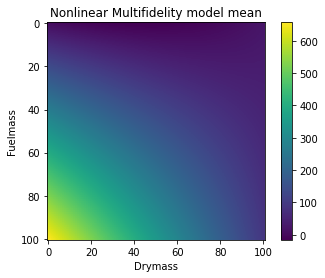

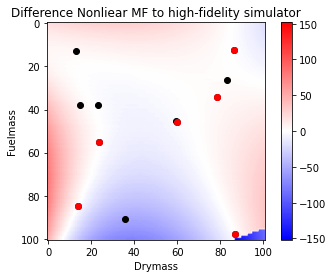

In [145]:
# Plot non-linear multifidelity model
hf_mean_hplot = hf_mean_nonlin_mf_model.reshape(num_points, num_points)
lf_mean_hplot = lf_mean_nonlin_mf_model.reshape(num_points, num_points)


# Mean high
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Nonlinear Multifidelity model mean')
im_high_mean = ax.imshow(hf_mean_hplot)
fig.colorbar(im_high_mean, ax=ax)
plt.show()

# Difference high
fig, ax = plt.subplots()
ax.set_xlabel('Drymass')
ax.set_ylabel('Fuelmass')
ax.set_title('Difference Nonliear MF to high-fidelity simulator')
im_diff = ax.imshow(y_plot_high_im - hf_mean_hplot, cmap='bwr', norm=colors.CenteredNorm())
ax.plot(x_tl_scaled[:,1], x_tl_scaled[:,0], 'ko')
ax.plot(x_th_scaled[:,1], x_th_scaled[:,0], 'ro') #Drymass,fuelmass
fig.colorbar(im_diff, ax=ax)
plt.show()

In [143]:
rmse_mf_nonlin = np.sqrt(np.mean(np.square(y_plot_high_im - hf_mean_hplot)))
print(rmse_gp)
print(rmse_mf_lin)
print(rmse_mf_nonlin)

30.51939615604498
45.86023772495594
22.644539636850727
